# Reinforcement Learning

https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/

![Reinforcement Learning](img/reinforcement-learning.jpg)

1. Being greedy doesn't always work
2. Sequence matters in Reinforcement Learning

## The Reinforcement Learning Process

1. Observation of the environment
2. Deciding how to act using some strategy
3. Acting accordingly
4. Receiving a reward or penalty
5. Learning from the experiences and refining our strategy
6. Iterate until an optimal strategy is found

![RL Animation](img/RL-animation.gif)

## Example Design: Self-Driving Cab

The Smartcab's job is to pick up the passenger at one location and drop them off in another. Here are a few things that we'd love our Smartcab to take care of:

Drop off the passenger to the right location.
Save passenger's time by taking minimum time possible to drop off
Take care of passenger's safety and traffic rules
There are different aspects that need to be considered here while modeling an RL solution to this problem: rewards, states, and actions.

### 1. Rewards
Since the agent (the imaginary driver) is reward-motivated and is going to learn how to control the cab by trial experiences in the environment, we need to decide the **rewards and/or penalties** and their magnitude accordingly. Here a few points to consider:

- a high positive reward for a successful dropoff because this behavior is highly desired
- penalty if the driver tries to drop off a passenger in wrong locations
- a slight negative reward for not making it to the destination after every time-step. "Slight" negative because we would prefer our agent to reach late instead of making wrong moves trying to reach to the destination as fast as possible

### 2. State Space
In Reinforcement Learning, the agent encounters a state, and then takes action according to the state it's in.

The **state space** is the set of all possible situations our taxi could inhabit. The state should contain useful information the agent needs to make the right action.

Let's say we have a training area for our Smartcab where we are teaching it to transport people in a parking lot to four different locations (R, G, Y, B):

![Open AI Taxi](img/open-ai-taxi.jpg)

Let's assume Smartcab is the only vehicle in this parking lot. We can break up the parking lot into a 5x5 grid, which gives us 25 possible taxi locations. These 25 locations are one part of our state space. Notice the current location state of our taxi is coordinate (3, 1).

You'll also notice there are four (4) locations that we can pick up and drop off a passenger: R, G, Y, B or `[(0,0), (0,4), (4,0), (4,3)]` in (row, col) coordinates. Our illustrated passenger is in location Y and they wish to go to location R.

When we also account for one (1) additional passenger state of being inside the taxi, we can take all combinations of passenger locations and destination locations to come to a total number of states for our taxi environment; there's four (4) destinations and five (4 + 1) passenger locations.

So, our taxi environment has 5×5×5×4=500 total possible states.

### 3. Action Space
The agent encounters one of the 500 states and it takes an action. The action in our case can be to move in a direction or decide to pickup/dropoff a passenger. In other words, we have six possible actions:

- `0 = south`
- `1 = north`
- `2 = east`
- `3 = west`
- `4 = pickup`
- `5 = dropoff`

This is the **action space**: the set of all the actions that our agent can take in a given state.

You'll notice in the illustration above, that the taxi cannot perform certain actions in certain states due to walls. In environment's code, we will simply provide a -1 penalty for every wall hit and the taxi won't move anywhere. This will just rack up penalties causing the taxi to consider going around the wall.

## Implementation with Python

The gym environment is provided by https://gym.openai.com/

In [ ]:
!pip install --no-deps -e src

In [1]:
import gym
import seaborn as sns

env = gym.make('Taxi-v3').env
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



_"There are 4 locations (labeled by different letters), and our job is to pick up the passenger at one location and drop him 
off at another. We receive +20 points for a successful drop-off and lose 1 point for every time-step it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions."_

- The filled square represents the taxi, which is yellow without a passenger and green with a passenger.
- The pipe ("|") represents a wall which the taxi cannot cross.
- R, G, Y, B are the possible pickup and destination locations. The blue letter represents the current passenger pick-up location, and the purple letter is the current destination.

In [2]:
env.reset() # reset environment to a new, random state
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


In [3]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



### The Reward Table

When the Taxi environment is created, there is an initial Reward table that's also created, called `P`. We can think of it like a matrix that has the number of states as rows and number of actions as columns, i.e. a states × actions matrix.

Actions are: `0 = south`, `1 = north`, `2 = east`, `3 = west`, `4 = pickup`, `5 = dropoff`

Since every state is in this matrix, we can see the default reward values assigned to our illustration's state. This dictionary has the structure `{action: [(probability, nextstate, reward, done)]}`.

In [4]:
env.P[328]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

A few things to note:

- The 0-5 corresponds to the actions (south, north, east, west, pickup, dropoff) the taxi can perform at our current state in the illustration.
- In this env, `probability` is always 1.0.
- The `nextstate` is the state we would be in if we take the action at this index of the dict
- All the movement actions have a -1 reward and the pickup/dropoff actions have -10 reward in this particular state. If we are in a state where the taxi has a passenger and is on top of the right destination, we would see a reward of 20 at the dropoff action (5)
- `done` is used to tell us when we have successfully dropped off a passenger in the right location. Each successfull dropoff is the end of an episode

Note that if our agent chose to explore action two (2) in this state it would be going East into a wall. The source code has made it impossible to actually move the taxi across a wall, so if the taxi chooses that action, it will just keep accruing -1 penalties, which affects the long-term reward.

### Solving the environment without Reinforcement Learning

Let's just use a random drive - taking a random action at each state.

In [5]:
env.s = 328  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 123
Penalties incurred: 37


In [6]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)
        
print_frames(frames[:200])

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 123
State: 0
Action: 5
Reward: 20


### Q-learning in Python

![Q-Learning](img/q-learning.jpg)

- Q-table with Q-values, for each `(state, action)` pair - representative of the quality of an action in the particular state
- alpha is the learning rate [0, 1]
- gamma is the discount factor [0, 1]

**Steps:**

1. Initialize the Q-table by all zeros.
2. Start exploring actions: For each state, select any one among all possible actions for the current state (S).
3. Travel to the next state (S') as a result of that action (a).
4. For all possible actions from the state (S') select the one with the highest Q-value.
5. Update Q-table values using the equation.
6. Set the next state as the current state.
7. If goal state is reached, then end and repeat the process.

There's a tradeoff between exploration (choosing a random action) and exploitation (choosing actions based on already learned Q-values):
- an additional parameter epsilon: the probability of exploration

In [7]:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [8]:
q_table

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [9]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1    # learning rate
gamma = 0.6    # discount factor of the future rewards
epsilon = 0.1  # probability of exploration vs exploitation

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 30001):
    state = env.reset()

    epochs, penalties = 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")
        
    all_epochs.append(epochs)
    all_penalties.append(penalties)

print("Training finished.\n")

Episode: 30000
Training finished.

Wall time: 47 s


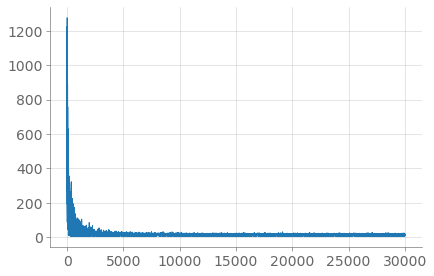

In [10]:
# number of timesteps to finish the episode
sns.lineplot(range(len(all_epochs)), all_epochs)

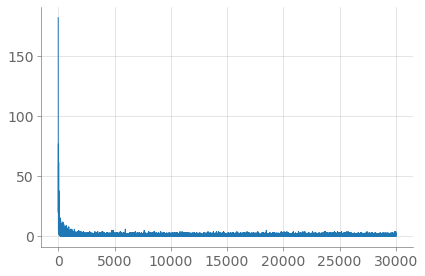

In [11]:
# penalties incurred in each episode
sns.lineplot(range(len(all_penalties)), all_penalties)

In [12]:
q_table

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ -2.41777658,  -2.36322746,  -2.41801578,  -2.3635322 ,
         -2.27325184, -11.32811778],
       [ -1.86607845,  -1.45417117,  -1.85664844,  -1.45105493,
         -0.7504    , -10.36207989],
       ...,
       [ -1.08831672,   0.36920534,  -1.08831672,  -1.09140694,
         -2.7753397 ,  -1.95809354],
       [ -2.13031397,  -2.11795723,  -2.1321916 ,  -2.11804834,
         -3.71285004,  -4.37948439],
       [  1.42144954,  -0.29302   ,   0.9051096 ,  10.99999848,
         -1.65040201,  -2.04804828]])

In [13]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 100

frames = [] # for animation

for ep in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1            
            
        epochs += 1
        
        if ep < 100:
            frames.append({
                'frame': env.render(mode='ansi'),
                'state': state,
                'action': action,
                'reward': reward
                })

        # clear_output(wait=True)
        # print(f"Episode: {ep}, timestep: {epochs}")            

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 100 episodes:
Average timesteps per episode: 13.18
Average penalties per episode: 0.0


In [16]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)
        
print_frames(frames[:1000])

+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (South)

Timestep: 1000
State: 318
Action: 0
Reward: -1
